In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch 
import torchvision
import os
import csv
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.transforms as T
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
data = "/content/drive/Shareddrives/Unlimited Storage/Plant-CFY/data"
train_path = "/content/drive/MyDrive/Colab Notebooks/plant-train.csv"
val_path = "/content/drive/MyDrive/Colab Notebooks/plant-val.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/plant-test.csv"

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def save_checkpoint(state,filename="/content/drive/MyDrive/Colab Notebooks/plantCFY_best_checkpoint2.pth.tar"):
  print("==> Saving Checkpoint")
  torch.save(state,filename)
  print("==> Checkpoint Saved")

def load_checkpoint(model,checkpoint):
  print("==> Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  print("==> Checkpoint Loaded")


In [ ]:
def MakeDataset(path):
  classes=os.listdir(path)
  print(classes)
  ftrain = open(train_path, 'w',newline='')
  wtrain = csv.writer(ftrain)
  wtrain.writerow(['name','class'])

  fval = open(val_path, 'w',newline='')
  wval = csv.writer(fval)
  wval.writerow(['name','class'])

  ftest = open(test_path, 'w',newline='')
  wtest = csv.writer(ftest)
  wtest.writerow(['name','class'])

  for c in range(len(classes)):
    dir=os.listdir(path+"/"+classes[c])
    train,temp= train_test_split(dir, test_size=0.2)
    val,test = train_test_split(temp, test_size=0.5)
    for i in train:
         wtrain.writerow([classes[c]+"/"+i,c])
    for j in val:
         wval.writerow([classes[c]+"/"+j,c])
    for k in test:
         wtest.writerow([classes[c]+"/"+k,c])     
  ftrain.close()
  fval.close()
  ftest.close()

In [ ]:
class GetDataset(Dataset):
    def __init__(self,datapath,csvpath,augment):
        self.datapath=datapath
        self.csvpath=csvpath
        self.augment = augment
        self.df=pd.read_csv(csvpath)
        self.transform=T.Compose([T.Resize(224),T.ToTensor()])
        self.augmentations = T.Compose([T.Resize(240),T.ToTensor(),T.RandomRotation((-90,90)),T.RandomHorizontalFlip(p=0.5),
                                 T.RandomVerticalFlip(p=0.5),T.RandomCrop(224),
                                 T.ColorJitter(brightness=(1,3),contrast=0,saturation=0,hue=0)])
    def __getitem__(self,index):
        self.img=Image.open(self.datapath+'/'+self.df.iloc[index,0])
        if(self.augment=="true"):
          self.input=self.augmentations(self.img)
        else:
          self.input=self.transform(self.img)      
        self.label=torch.tensor(self.df.iloc[index,1])
        return self.input,self.label
    def __len__(self):
        return len(self.df)

In [ ]:
def LoadDataset(data,train_path,val_path,test_path,batch_size):
  train_ds = GetDataset(data,train_path,augment="true")
  val_ds = GetDataset(data,val_path,augment="true")
  test_ds = GetDataset(data,test_path,augment="false")

  train_loader=DataLoader(train_ds,batch_size,shuffle=True)
  val_loader=DataLoader(val_ds,batch_size,shuffle=True)
  test_loader=DataLoader(test_ds,batch_size,shuffle=False)
  return train_loader,val_loader,test_loader

In [ ]:
def GetModel(no_of_classes,lr):
  model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
  n_inputs = model.fc.in_features
  last_layer = nn.Linear(n_inputs,no_of_classes)
  model.fc= last_layer
  model = model.to(device)
  print("Input Features:",model.fc.in_features)
  print("Output Features:",model.fc.out_features)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(),lr=lr)
  return model,criterion,optimizer


In [ ]:
def trainer(model,epochs,train_loader,val_loader,criterion,optimizer):
  #Model training and saving best model 
  #load_checkpoint(model,torch.load("/content/drive/MyDrive/Colab Notebooks/plantCFY_best_checkpoint2.pth.tar")) 
  epoch_loss=[]
  train_acc=[]
  val_acc=[]
  best_accuracy = 0.0
  for epoch in range(epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_loss=0.0
    train_accuracy=0.0
    val_accuracy=0.0
    len1=0
    len2=0

    loop = tqdm(train_loader)
    for images,labels in loop:
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        optimizer.zero_grad()
        outputs=model(images)
        m = nn.LogSoftmax(dim=1)
        loss=criterion(m(outputs),labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss
        len1 += labels.shape[0]
        prediction=m(outputs).argmax(dim=1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/len1
    train_loss=(train_loss/len1).data.item()
    epoch_loss.append(train_loss)
    train_acc.append(train_accuracy)
    
    
    loop = tqdm(val_loader)  
    
    for images,labels in loop:
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        outputs=model(images)
        len2 += labels.shape[0]
        prediction=m(outputs).argmax(dim=1)
        
        val_accuracy+=int(torch.sum(prediction==labels.data))
        
    val_accuracy=val_accuracy/len2
    val_acc.append(val_accuracy)

    print('\nEpoch:'+str(epoch+1)+' Train Loss: '+str(round(train_loss,5))+' Train Accuracy: '+str(round(train_accuracy,5))+' Val Accuracy: '+str(round(val_accuracy,5)))

    if val_accuracy>=best_accuracy:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)
        best_accuracy=val_accuracy

  return epoch_loss,train_acc,val_acc


In [ ]:
# Evaluation on testing dataset
def tester(model,test_loader):
  model.eval()
  test_accuracy=0.0
  len2=0
  loop1 = tqdm(test_loader)
  for i, (images,labels) in enumerate(loop1):
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        outputs=model(images)
        m = nn.LogSoftmax(dim=1)
        prediction=m(outputs).argmax(dim=1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        len2 += labels.shape[0]
    
  test_accuracy=test_accuracy/len2
  print('\n\n********************************************************************************')
  print('\n Test Accuracy: '+str(round(test_accuracy,5)))
  print('\n********************************************************************************\n\n')

In [ ]:
def plotgraphs(epochs,epoch_loss,train_acc,val_acc):
  plt.figure(figsize=[20,6])
  plt.subplot(121)
  plt.plot(range(epochs),epoch_loss,label='Train Loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Epoch loss')
  plt.title('Loss Curve')
  plt.subplot(122)
  plt.plot(range(epochs),train_acc,color='red',label='Train Accuracy')
  plt.plot(range(epochs),val_acc,color='blue',label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs Validation Accuracy')

In [ ]:
def main():
  lr=0.0001
  epochs = 20
  no_of_classes = 12
  batch_size=16
  MakeDataset(data)
  train_loader,val_loader,test_loader=LoadDataset(data,train_path,val_path,test_path,batch_size)
  model,criterion,optimizer = GetModel(no_of_classes,lr)
  epoch_loss,train_acc,val_acc= trainer(model,epochs,train_loader,val_loader,criterion,optimizer)
  tester(model,test_loader)
  plotgraphs(epochs,epoch_loss,train_acc,val_acc)

['Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet', 'Black-grass', 'Charlock']


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Input Features: 2048
Output Features: 12


100%|██████████| 30/30 [04:44<00:00,  9.48s/it]



Epoch:1 Train Loss: 0.07649 Train Accuracy: 0.62862 Val Accuracy: 0.85232
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.16it/s]



Epoch:2 Train Loss: 0.02142 Train Accuracy: 0.8864 Val Accuracy: 0.88608
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.24it/s]



Epoch:3 Train Loss: 0.01446 Train Accuracy: 0.92383 Val Accuracy: 0.91139
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.24it/s]



Epoch:4 Train Loss: 0.01162 Train Accuracy: 0.93595 Val Accuracy: 0.91983
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.20it/s]



Epoch:5 Train Loss: 0.00968 Train Accuracy: 0.9486 Val Accuracy: 0.93038
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.25it/s]



Epoch:6 Train Loss: 0.00886 Train Accuracy: 0.95335 Val Accuracy: 0.92405


100%|██████████| 30/30 [00:05<00:00,  5.12it/s]



Epoch:7 Train Loss: 0.00825 Train Accuracy: 0.95677 Val Accuracy: 0.91139


100%|██████████| 30/30 [00:05<00:00,  5.13it/s]



Epoch:8 Train Loss: 0.00721 Train Accuracy: 0.96205 Val Accuracy: 0.94304
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.22it/s]



Epoch:9 Train Loss: 0.00772 Train Accuracy: 0.95836 Val Accuracy: 0.9346


100%|██████████| 30/30 [00:05<00:00,  5.31it/s]



Epoch:10 Train Loss: 0.00596 Train Accuracy: 0.96811 Val Accuracy: 0.94304
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.25it/s]



Epoch:11 Train Loss: 0.00577 Train Accuracy: 0.96995 Val Accuracy: 0.94304
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.27it/s]



Epoch:12 Train Loss: 0.00564 Train Accuracy: 0.97074 Val Accuracy: 0.95148
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.31it/s]



Epoch:13 Train Loss: 0.00478 Train Accuracy: 0.97522 Val Accuracy: 0.95148
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.27it/s]



Epoch:14 Train Loss: 0.00512 Train Accuracy: 0.97259 Val Accuracy: 0.95992
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.26it/s]



Epoch:15 Train Loss: 0.00458 Train Accuracy: 0.97628 Val Accuracy: 0.96414
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.26it/s]



Epoch:16 Train Loss: 0.00402 Train Accuracy: 0.97549 Val Accuracy: 0.96624
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 30/30 [00:05<00:00,  5.25it/s]



Epoch:17 Train Loss: 0.00369 Train Accuracy: 0.97654 Val Accuracy: 0.95148


100%|██████████| 30/30 [00:05<00:00,  5.11it/s]



Epoch:18 Train Loss: 0.00354 Train Accuracy: 0.97997 Val Accuracy: 0.95781


100%|██████████| 30/30 [00:05<00:00,  5.33it/s]



Epoch:19 Train Loss: 0.00354 Train Accuracy: 0.98102 Val Accuracy: 0.94093


100%|██████████| 30/30 [00:05<00:00,  5.35it/s]



Epoch:20 Train Loss: 0.00367 Train Accuracy: 0.97839 Val Accuracy: 0.95781


100%|██████████| 31/31 [04:47<00:00,  9.29s/it]




********************************************************************************

 Test Accuracy: 0.96473

********************************************************************************




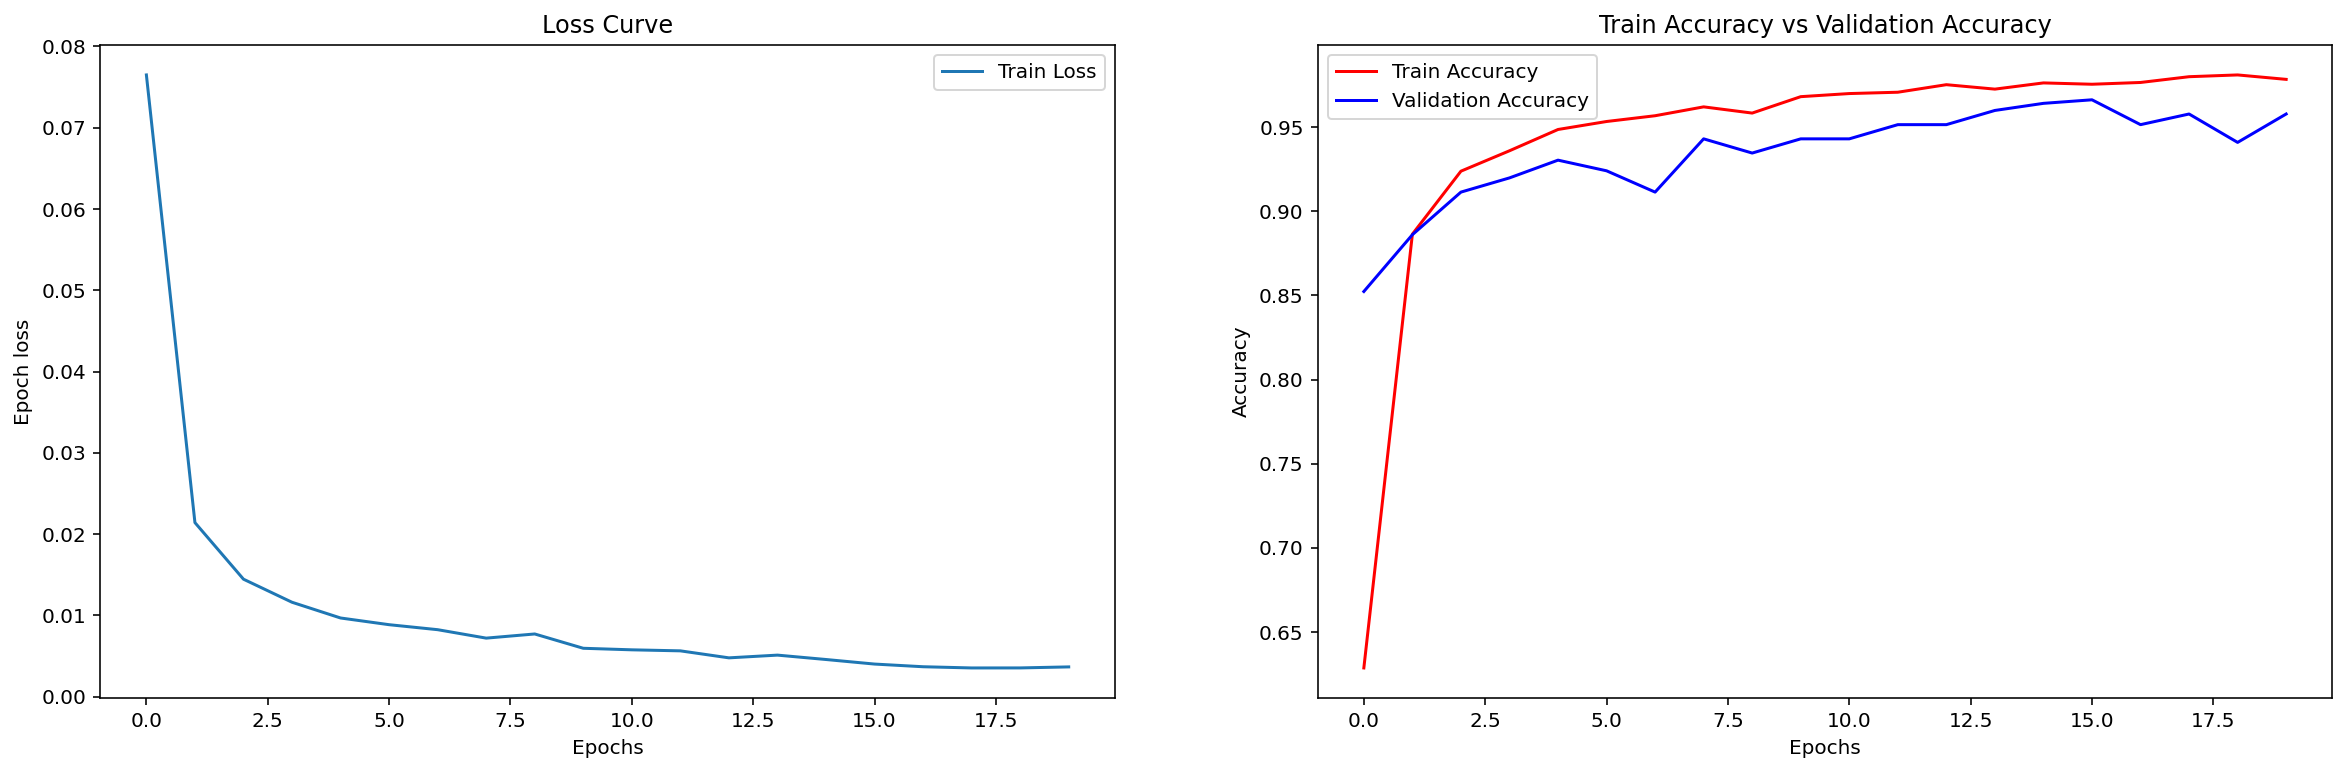

In [ ]:
if __name__ == "__main__":
    main()